<a href="https://colab.research.google.com/github/Mat11-py/NLP_project/blob/main/Final_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO FINAL
El desafío a realizarse consiste en realizar un estudios exploratorio de 3 modelos en la tarea de clasificación de emociones (https://github.com/fmplaza/EmoEvent/tree/master/splits). Este dataset contiene 8409 tweets anotados con una de las siguientes categorías: anger, sadness, joy, disgust, fear, surprise, offensive, other. Además, los tweets están relacionados a eventos particulares encontrados en Twitter.

# 1. IMPORTAR O DESCARGAR LIBRERÍAS

In [1]:
!pip install transformers==4.47.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 360.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.4
    Uninstalling transformers-4.55.4:
      Successfully uninstalled transformers-4.55.4


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam

# 2. CARGA DE DATOS

In [3]:
path = "/content/drive/MyDrive/PhawAi/NLP/EmoEvent-master/emoevent_en.csv"

In [4]:
df = pd.read_csv(path,sep="\t")

# 3. PREPROCESAMIENTO


In [5]:
df.head()

,id,tweet,emotion,offensive
0,1,Something to keep in mind... When situations l...,disgust,0
1,2,I'm really sorry about a whole history of 850 ...,sadness,0
2,3,The kid in me is sobbing at all the Hunchback ...,sadness,0
3,4,HASHTAG April30 New thread to share. A large g...,others,0
4,5,It’s World Book Day and a great day to visit t...,joy,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7303 entries, 0 to 7302
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         7303 non-null   int64 
 1   tweet      7303 non-null   object
 2   emotion    7303 non-null   object
 3   offensive  7303 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 228.3+ KB


In [7]:
df.isnull().sum()

,0
id,0
tweet,0
emotion,0
offensive,0


In [8]:
df.describe(include="all")

,id,tweet,emotion,offensive
count,7303.000000,7303,7303,7303.000000
unique,NaN,7303,7,NaN
top,NaN,YALL CANT TELL ME SHIT RIGHT NOW HASHTAG URL,others,NaN
freq,NaN,1,3305,NaN
mean,3652.000000,NaN,NaN,0.070930
std,2108.338841,NaN,NaN,0.256725
min,1.000000,NaN,NaN,0.000000
25%,1826.500000,NaN,NaN,0.000000
50%,3652.000000,NaN,NaN,0.000000
75%,5477.500000,NaN,NaN,0.000000


In [9]:
df["emotion"].unique()

array(['disgust', 'sadness', 'others', 'joy', 'anger', 'surprise', 'fear'],
      dtype=object)

In [10]:
ea = df.emotion.value_counts().reset_index() # ea -> emotion analysis
ea

,emotion,count
0,others,3305
1,joy,2039
2,disgust,765
3,sadness,416
4,anger,392
5,surprise,235
6,fear,151


In [11]:
ea.columns

Index(['emotion', 'count'], dtype='object')

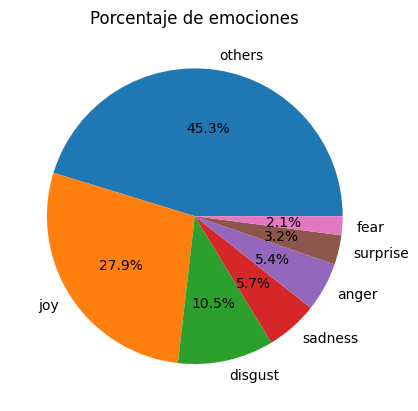

In [12]:
plt.pie(ea['count'], labels=ea['emotion'], autopct="%1.1f%%")
plt.title("Porcentaje de emociones")
plt.show()

In [13]:
oa = df.offensive.value_counts().reset_index() # oa -> offensive analysis
oa

,offensive,count
0,0,6785
1,1,518


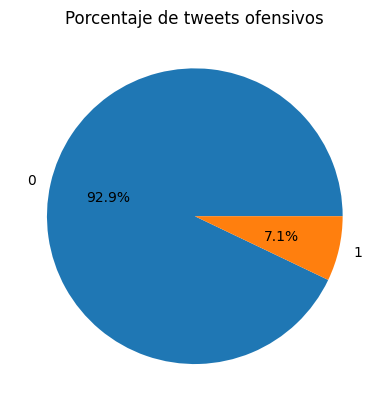

In [14]:
plt.pie(oa['count'], labels=oa['offensive'], autopct="%1.1f%%")
plt.title("Porcentaje de tweets ofensivos")
plt.show()

In [15]:
df.duplicated().sum()

np.int64(0)

In [16]:
def limpiar_texto(texto):
    """
    Limpieza de los tweets
    """
    texto = texto.lower()  # todo minúscula
    texto = re.sub(r'http\S+', '', texto)  # quitar URLs
    texto = re.sub(r'@\w+', '', texto)  # quitar menciones
    texto = re.sub(r'#\w+', '', texto)  # quitar hashtags
    texto = re.sub(r'\d+', '', texto)  # quitar números
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # quitar puntuación
    texto = re.sub(r'\s+', ' ', texto).strip()  # quitar espacios extras
    return texto

In [17]:
df['clean_tweet'] = df['tweet'].apply(limpiar_texto)

In [18]:
df.head()

,id,tweet,emotion,offensive,clean_tweet
0,1,Something to keep in mind... When situations l...,disgust,0,something to keep in mind when situations like...
1,2,I'm really sorry about a whole history of 850 ...,sadness,0,im really sorry about a whole history of years...
2,3,The kid in me is sobbing at all the Hunchback ...,sadness,0,the kid in me is sobbing at all the hunchback ...
3,4,HASHTAG April30 New thread to share. A large g...,others,0,hashtag april new thread to share a large grou...
4,5,It’s World Book Day and a great day to visit t...,joy,0,it’s world book day and a great day to visit t...


In [19]:
le = LabelEncoder() #objeto codificador de etiquetas


df['emotion_encoded'] = le.fit_transform(df['emotion'])#transformación

# mapeo de clases
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'anger': np.int64(0), 'disgust': np.int64(1), 'fear': np.int64(2), 'joy': np.int64(3), 'others': np.int64(4), 'sadness': np.int64(5), 'surprise': np.int64(6)}


In [20]:
df.head()

,id,tweet,emotion,offensive,clean_tweet,emotion_encoded
0,1,Something to keep in mind... When situations l...,disgust,0,something to keep in mind when situations like...,1
1,2,I'm really sorry about a whole history of 850 ...,sadness,0,im really sorry about a whole history of years...,5
2,3,The kid in me is sobbing at all the Hunchback ...,sadness,0,the kid in me is sobbing at all the hunchback ...,5
3,4,HASHTAG April30 New thread to share. A large g...,others,0,hashtag april new thread to share a large grou...,4
4,5,It’s World Book Day and a great day to visit t...,joy,0,it’s world book day and a great day to visit t...,3


In [21]:
df.columns

Index(['id', 'tweet', 'emotion', 'offensive', 'clean_tweet',
       'emotion_encoded'],
      dtype='object')

In [22]:
df.shape[0]

7303

In [23]:
X = df['clean_tweet']
y = df['emotion_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y, #compensación de equitas
    random_state=42
)

# Tamaño de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test))


Tamaño del conjunto de entrenamiento: 5842
Tamaño del conjunto de prueba: 1461


# 4. MODELAMIENTO

In [37]:
def visualizacion_resultados(history,n):
  """
  visualización de la evaluación según accuracy
  """
  epochs = [i for i in range(n)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16,9)

  ax[0].plot(epochs, train_acc, "go-",label = "Entrenamiento accuracy")
  ax[0].plot(epochs, val_acc, "ro-",label = "Validación accuracy")
  ax[0].set_title("Entrenamiento y validación accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, train_loss, "go-",label = "Entrenamiento loss")
  ax[1].plot(epochs, val_loss, "ro-",label = "Validación loss")
  ax[1].set_title("Entrenamiento y validación loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()

## 4.1 LSTM

In [24]:
# Hiperparámetros
vocab_size = 10000  # número máximo de palabras a considerar
max_length = 100     # longitud máxima del tweet
oov_token = "<OOV>" # palabras fuera de vocabulario

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

tokenizer.fit_on_texts(X_train)

# Convertir textos a secuencias de enteros
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Rellenar las secuencias para que todas tengan la misma longitud
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print("Texto original:", X_train.iloc[0])
print("Secuencia:", X_train_seq[0])
print("Secuencia padded:", X_train_pad[0])


Texto original: user user user user this is what happens when the government takes away your guns and ability to fight back against tyranny hashtag hashtag hashtag
Secuencia: [6, 6, 6, 6, 16, 11, 26, 592, 65, 3, 215, 743, 262, 32, 1054, 9, 1674, 5, 234, 141, 150, 1675, 2, 2, 2]
Secuencia padded: [   6    6    6    6   16   11   26  592   65    3  215  743  262   32
 1054    9 1674    5  234  141  150 1675    2    2    2    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [25]:
num_classes = len(df['emotion_encoded'].unique()) #Clases

# Codificación one-hot
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)


In [26]:
# Modelo
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(150, return_sequences=False)),
    #Dense(10000, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
history = model.fit(
    X_train_pad,
    y_train_cat,
    validation_split=0.1,
    epochs=15,
    batch_size=32,
    verbose=1
)


Epoch 1/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 43s 225ms/step - accuracy: 0.4166 - loss: 1.6798 - val_accuracy: 0.4701 - val_loss: 1.5069
Epoch 2/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 36s 217ms/step - accuracy: 0.4543 - loss: 1.4435 - val_accuracy: 0.4701 - val_loss: 1.4829
Epoch 3/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.4654 - loss: 1.4072 - val_accuracy: 0.4855 - val_loss: 1.4396
Epoch 4/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 36s 220ms/step - accuracy: 0.5093 - loss: 1.3083 - val_accuracy: 0.4889 - val_loss: 1.3697
Epoch 5/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 37s 225ms/step - accuracy: 0.5726 - loss: 1.1838 - val_accuracy: 0.5299 - val_loss: 1.3369
Epoch 6/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 36s 220ms/step - accuracy: 0.6063 - loss: 1.1239 - val_accuracy: 0.5145 - val_loss: 1.3815
Epoch 7/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.6464 - loss: 1.0286 - val_accuracy: 0.5111 - val_loss: 1.3628
Epoch 8/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - accuracy: 0.6655 - loss: 0

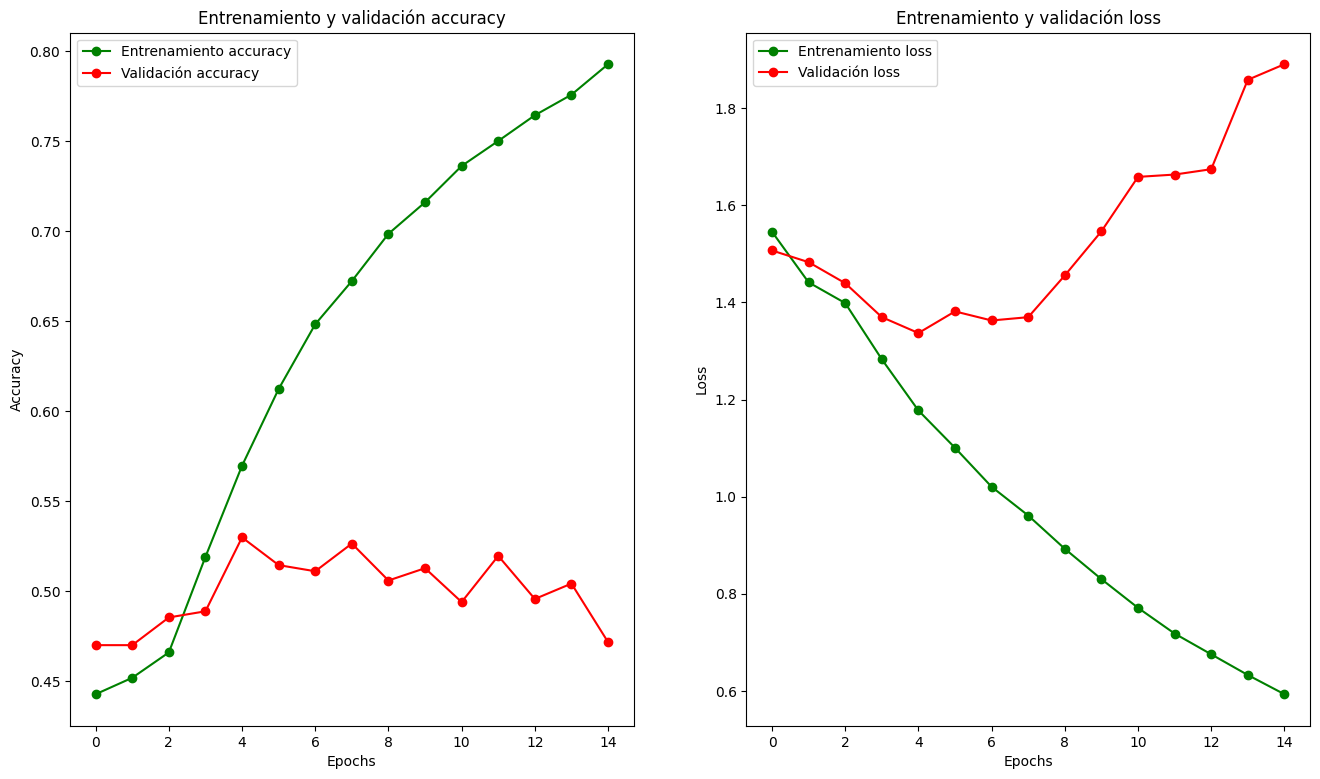

In [38]:
visualizacion_resultados(history,15)

In [30]:
# Predicciones LSTM
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)


print(classification_report(y_true, y_pred, target_names=le.classes_))

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        79
     disgust       0.25      0.41      0.31       153
        fear       0.00      0.00      0.00        30
         joy       0.52      0.51      0.52       408
      others       0.52      0.61      0.56       661
     sadness       0.16      0.04      0.06        83
    surprise       0.00      0.00      0.00        47

    accuracy                           0.47      1461
   macro avg       0.21      0.22      0.21      1461
weighted avg       0.41      0.47      0.43      1461



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


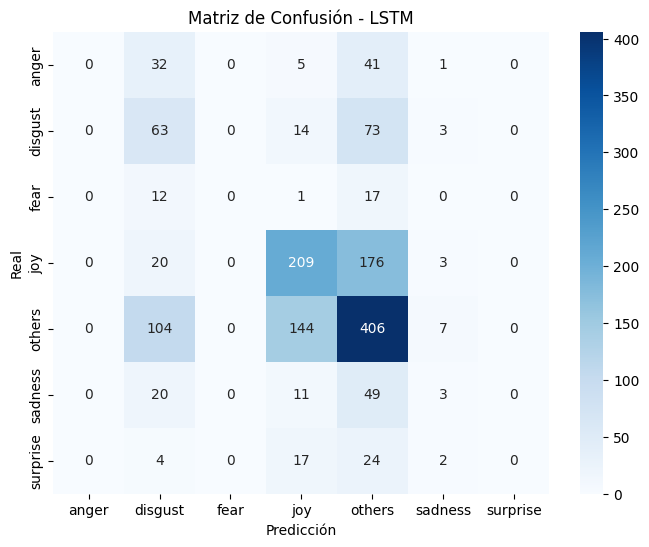

In [31]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - LSTM')
plt.show()


# 4.2 GRU

In [35]:
model_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    GRU(150, return_sequences=False),
    #Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
history_gru = model_gru.fit(
    X_train_pad,
    y_train_cat,
    validation_split=0.1,
    epochs=15,
    batch_size=32,
    verbose=1
)


Epoch 1/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.3823 - loss: 1.7579 - val_accuracy: 0.4701 - val_loss: 1.5146
Epoch 2/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.4543 - loss: 1.4675 - val_accuracy: 0.4701 - val_loss: 1.5117
Epoch 3/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 38s 125ms/step - accuracy: 0.4581 - loss: 1.4515 - val_accuracy: 0.4701 - val_loss: 1.5056
Epoch 4/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - accuracy: 0.4561 - loss: 1.4448 - val_accuracy: 0.4701 - val_loss: 1.5086
Epoch 5/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.4495 - loss: 1.4616 - val_accuracy: 0.4701 - val_loss: 1.5159
Epoch 6/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.4439 - loss: 1.4867 - val_accuracy: 0.4701 - val_loss: 1.5177
Epoch 7/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.4426 - loss: 1.4794 - val_accuracy: 0.4701 - val_loss: 1.5102
Epoch 8/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.4629 - loss: 1

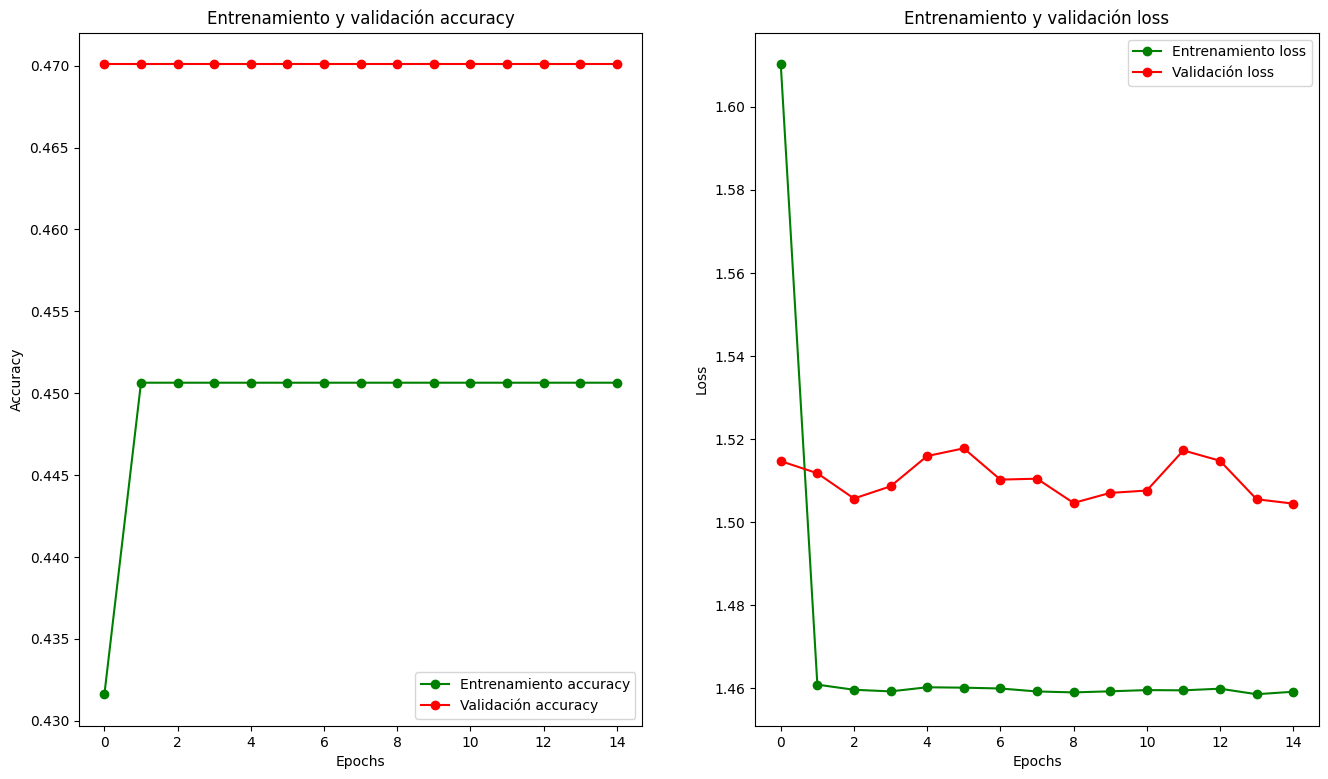

In [39]:
visualizacion_resultados(history_gru,15)

In [40]:
# Predicciones gru
y_pred_probs = model_gru.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)


print(classification_report(y_true, y_pred, target_names=le.classes_))

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        79
     disgust       0.00      0.00      0.00       153
        fear       0.00      0.00      0.00        30
         joy       0.00      0.00      0.00       408
      others       0.45      1.00      0.62       661
     sadness       0.00      0.00      0.00        83
    surprise       0.00      0.00      0.00        47

    accuracy                           0.45      1461
   macro avg       0.06      0.14      0.09      1461
weighted avg       0.20      0.45      0.28      1461



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


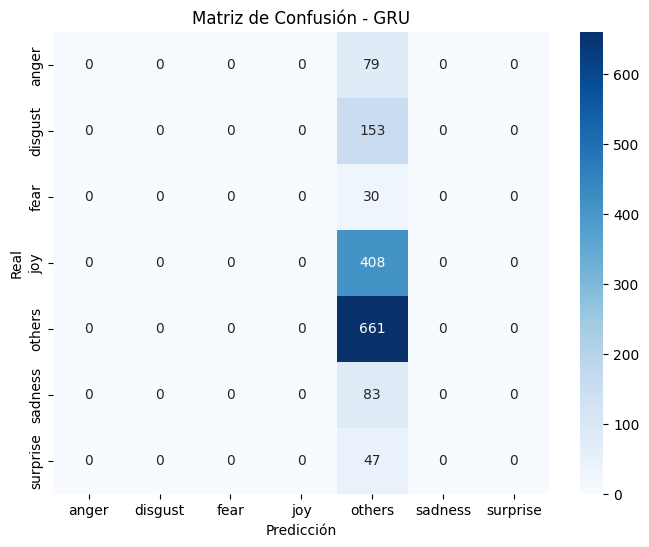

In [41]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - GRU')
plt.show()